In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Torch version:", torch.__version__)


CUDA available: True
GPU: NVIDIA GeForce GTX 1080
Torch version: 2.1.2+cu118


In [2]:
import sys
import os

# Add the root folder to path (assuming /Notebooks/ is in /DL_Final_Project/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

In [3]:
# # Cell 1: Visualize training losses
# import json
# import numpy as np
# import matplotlib.pyplot as plt

# print("Device", os.environ.get("CUDA_VISIBLE_DEVICES", "CPU"))

# extension = '4y'

# # Load both JSON files.
# with open(f"../trans_loss_{extension}", "r") as f:
#     trans_losses = json.load(f)

# with open(f"../rot_loss_{extension}", "r") as f:
#     rot_losses = json.load(f)

# episodes = np.arange(1, len(trans_losses) + 1)

# plt.figure(figsize=(10, 4))
# plt.plot(rot_losses, label="Rotation Loss", color="orange")
# plt.plot(trans_losses, label="Translation Loss", color="blue")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.title("Training Loss Curves")
# plt.legend()
# plt.grid(True)
# plt.show()


In [4]:
# --- Imports ---

import json
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import os
import yaml
import sys


In [ ]:
 # --- Config ---

from Classes.Dataset.IPDDataset_render import IPDDatasetMounted
from Models.PoseEstimatorSeen.PoseEstimation import PoseEstimator


config_path = "../Config/config_fusenet.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

remote_base_url = f"../{config['dataset']['remote_base_url']}"
cam_ids = config["dataset"]["cam_ids"]
modalities = config["dataset"].get("modality", ["rgb", "depth"])

# For seen CAD models, use the training split and same allowed objects as in training.
train_scene_ids = {f"{i:06d}" for i in range(0, 25)}
train_obj_ids = {0, 8, 18, 19, 20}
batch_size = 1
num_workers = 4

dataset = IPDDatasetMounted(
    remote_base_url,
    cam_ids,
    modalities,
    split=config["dataset"].get("train_split", "train"),  # using training split
    allowed_scene_ids=train_scene_ids,
    allowed_obj_ids=train_obj_ids
)

sensory_channels = {mod: 1 for mod in modalities}
encoder_type = config["training"].get("encoder", "fusenet")
fusion_type = config["training"].get("fusion", "concat")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
renderer_config = config.get("renderer", {"width": 640, "height": 480, "device": device})

model = PoseEstimator(
        sensory_channels,
        encoder_type=encoder_type,
        fusion_type=fusion_type,
        obj_ids=train_obj_ids,
        n_views=len(cam_ids),
    ).to(device)

model_path = f"../weights/pose_model_{encoder_type}_{fusion_type}_{len(modalities)}_{len(cam_ids)}.pt"

c:\Users\RoseP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\RoseP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def move_sample_to_device(sample, device):
    X, Y = sample["X"], sample["Y"]

    for view in X["views"]:
        for k in view:
            view[k] = view[k].to(device)

    X["K"] = X["K"].to(device)

    for pose in Y["gt_poses"]:
        pose["R"] = pose["R"].to(device)
        pose["t"] = pose["t"].to(device)
        pose["obj_id"] = pose["obj_id"].to(device)

    # for obj_id in X["model_points_by_id"]:
    #     X["model_points_by_id"][obj_id] = X["model_points_by_id"][obj_id].to(device)

    for extr in X.get("extrinsics", []):
        extr["R_w2c"] = extr["R_w2c"].to(device)
        extr["t_w2c"] = extr["t_w2c"].to(device)

    return sample


Loading model weights from ../weights/pose_model_resnet_concat_1_1.pt...
Loading model weights...
Loading RGB image from ../ipd_data/ipd/val/000000/rgb_cam1/000000.png
RGB image shape: (2160, 3840)
RGB image shape: torch.Size([1, 480, 640])
img_tensor: torch.Size([1, 480, 640])


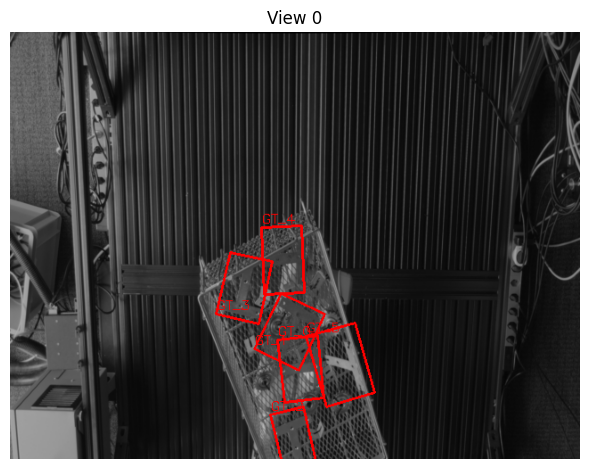

In [ ]:
import os
import cv2
import torch
import numpy as np
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

from Models.helpers import quaternion_to_matrix
from Models.PoseEstimatorSeen.PoseEstimation import PoseEstimator
from Metrics.visualization import draw_pose_axes, draw_rotated_2d_bbox_from_pose

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model weights
print(f"Loading model weights from {model_path}...")
if os.path.exists(model_path):
    print("Loading model weights...")
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print(f"[ERROR] Model path not found: {model_path}")
model.eval()

# --- Load a sample from dataset ---
sample = dataset.__getitem__(0)  # Load the first sample from the dataset
sample = move_sample_to_device(sample, device)
X, Y = sample["X"], sample["Y"]
K_list = X["K"]

# Inference
with torch.no_grad():
    detections, _ = model(
        x_dict_views=X["views"],
        K_list=X["K"],
        extrinsics=X["extrinsics"],  # pass extrinsics if model supports it
        top_k=50
    )

# Choose the render mode: "axes" or "bbox"
render_mode = "bbox"

# Get number of views
num_views = len(X["views"])
fig, axes = plt.subplots(1, num_views, figsize=(6 * num_views, 6))
if num_views == 1:
    axes = [axes]

for idx, view in enumerate(X["views"]):
    img_tensor = view["rgb"].cpu()
    print("img_tensor:", img_tensor.shape)
    img_pil = ToPILImage()(img_tensor)
    img_rgb = np.array(img_pil.convert("RGB"))
    vis = img_rgb.copy()

    K_np = K_list[idx].cpu().numpy()

    # Draw GT poses in red
    for i, gt in enumerate(Y["gt_poses"]):
        # gt = Y["gt_poses"][11]
        R_gt = gt["R"].cpu().numpy()
        t_gt = gt["t"].cpu().numpy()
        # print("t_gt:", t_gt)
        # print("R_gt:", R_gt)
        # print("K_np:", K_np)
        if render_mode == "axes":
            vis = draw_pose_axes(vis, R_gt, t_gt, K_np, label=f"GT_{i}", color=(255, 0, 0))
        else:
            vis = draw_rotated_2d_bbox_from_pose(vis, R_gt, t_gt, K_np, label=f"GT_{i}", color=(255, 0, 0))

    # Draw predictions in green
    # for i, det in enumerate(detections):
    #     R_pred = quaternion_to_matrix(det["quat"].unsqueeze(0))[0].cpu().numpy()
    #     t_pred = det["trans"].cpu().numpy()
    #     if render_mode == "axes":
    #         vis = draw_pose_axes(vis, R_pred, t_pred, K_np, label=f"Pred_{i}", color=(0, 255, 0))
    #     else:
    #         vis = draw_bbox_from_pose(vis, R_pred, t_pred, K_np, label=f"Pred_{i}", color=(0, 255, 0))

    axes[idx].imshow(vis)
    axes[idx].set_title(f"View {idx}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()
